The EDEX modelsounding plugin creates 64-level vertical profiles from GFS and ETA (NAM) BUFR products distirubted over NOAAport. Paramters which are requestable are **pressure**, **temperature**, **specHum**, **uComp**, **vComp**, **omega**, **cldCvr**.

In [17]:
from awips.dataaccess import DataAccessLayer
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from math import exp, log
import numpy as np

DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
request = DataAccessLayer.newDataRequest()
request.setDatatype("modelsounding")
forecastModel = "GFS"
request.addIdentifier("reportType", forecastModel)
request.setParameters("pressure","temperature","specHum","uComp","vComp","omega","cldCvr")
locations = DataAccessLayer.getAvailableLocationNames(request)
locations.sort()
list(locations)

['CHE',
 'CRL',
 'EAX',
 'HSI',
 'KDSM',
 'KFOE',
 'KFRM',
 'KFSD',
 'KGRI',
 'KLNK',
 'KMCI',
 'KMCW',
 'KMHE',
 'KMHK',
 'KMKC',
 'KOFK',
 'KOMA',
 'KRSL',
 'KSLN',
 'KSTJ',
 'KSUX',
 'KTOP',
 'KYKN',
 'OAX',
 'P#8',
 'P#9',
 'P#A',
 'P#G',
 'P#I',
 'RDD',
 'WSC']

In [23]:
request.setLocationNames("KMCI")
cycles = DataAccessLayer.getAvailableTimes(request, True)
times = DataAccessLayer.getAvailableTimes(request)

try:
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)
    list(fcstRun)
    response = DataAccessLayer.getGeometryData(request,[fcstRun[0]])
except:
    print('No times available')
    exit

In [35]:
tmp,prs,sh = np.array([]),np.array([]),np.array([])
uc,vc,om,cld = np.array([]),np.array([]),np.array([]),np.array([])

for ob in response:
    tmp = np.append(tmp,ob.getNumber("temperature"))
    prs = np.append(prs,ob.getNumber("pressure"))
    sh = np.append(sh,ob.getNumber("specHum"))
    uc = np.append(uc,ob.getNumber("uComp"))
    vc = np.append(vc,ob.getNumber("vComp"))
    om = np.append(om,ob.getNumber("omega"))
    cld = np.append(cld,ob.getNumber("cldCvr"))

print("parms    = " + str(ob.getParameters()))
print("site     = " + str(ob.getLocationName()))
print("geom     = " + str(ob.getGeometry()))
print("datetime = " + str(ob.getDataTime()))
print("reftime  = " + str(ob.getDataTime().getRefTime()))
print("fcstHour = " + str(ob.getDataTime().getFcstTime()))
print("period   = " + str(ob.getDataTime().getValidPeriod()))
sounding_title = forecastModel + " "  + str(ob.getLocationName())  + "("+ str(ob.getGeometry())+")" + str(ob.getDataTime())

parms    = ['uComp', 'cldCvr', 'temperature', 'vComp', 'pressure', 'omega', 'specHum']
site     = KMCI
geom     = POINT (-94.72000122070312 39.31999969482422)
datetime = 1970-01-18 04:45:50.400000 (0)
reftime  = Jan 18 70 04:45:50 GMT
fcstHour = 0
period   = (Jan 18 70 04:45:50 , Jan 18 70 04:45:50 )


## Create data arrays and calculate dewpoint from spec. humidity

In [36]:
from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile, dewpoint
from metpy.calc import get_wind_speed,get_wind_dir, thermo, vapor_pressure
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

# we can use units.* here...
t = (tmp-273.15) * units.degC
p = prs/100 * units.mbar

u,v = uc*1.94384,vc*1.94384 # m/s to knots
spd = get_wind_speed(u, v) * units.knots
dir = get_wind_dir(u, v) * units.deg

## Dewpoint from Specific Humidity

Because the modelsounding plugin does not return dewpoint values, we must calculate the profile ourselves.  Here are three examples of dewpoint calculated from specific humidity, including a manual calculation following NCEP AWIPS/NSHARP. 

### 1) metpy calculated mixing ratio and vapor pressure

In [37]:
from metpy.calc import get_wind_components, lcl, dry_lapse, parcel_profile, dewpoint
from metpy.calc import get_wind_speed,get_wind_dir, thermo, vapor_pressure
from metpy.plots import SkewT, Hodograph
from metpy.units import units, concatenate

# we can use units.* here...
t = (tmp-273.15) * units.degC
p = prs/100 * units.mbar

u,v = uc*1.94384,vc*1.94384 # m/s to knots
spd = get_wind_speed(u, v) * units.knots
dir = get_wind_dir(u, v) * units.deg

In [38]:
rmix = (sh/(1-sh)) *1000 * units('g/kg')
e = vapor_pressure(p, rmix)
td = dewpoint(e)

/Users/mj/miniconda2/lib/python2.7/site-packages/MetPy-0.3.0+34.gcf954c5-py2.7.egg/metpy/calc/thermo.py:371: RuntimeWarning: divide by zero encountered in log
  val = np.log(e / sat_pressure_0c)
/Users/mj/miniconda2/lib/python2.7/site-packages/pint/quantity.py:1236: RuntimeWarning: divide by zero encountered in log
  out = uf(*mobjs)
/Users/mj/miniconda2/lib/python2.7/site-packages/pint/quantity.py:693: RuntimeWarning: invalid value encountered in true_divide
  magnitude = magnitude_op(self._magnitude, other_magnitude)


### 2) metpy calculated assuming spec. humidity = mixing ratio

In [39]:
td2 = dewpoint(vapor_pressure(p, sh))

### 3) NCEP AWIPS soundingrequest plugin
based on GEMPAK/NSHARP, from https://github.com/Unidata/awips2-ncep/blob/unidata_16.2.2/edex/gov.noaa.nws.ncep.edex.plugin.soundingrequest/src/gov/noaa/nws/ncep/edex/plugin/soundingrequest/handler/MergeSounding.java#L1783

In [40]:
# new arrays
ntmp = tmp

# where p=pressure(pa), T=temp(C), T0=reference temp(273.16)
rh = 0.263*prs*sh / (np.exp(17.67*ntmp/(ntmp+273.15-29.65)))
vaps =  6.112 * np.exp((17.67 * ntmp) / (ntmp + 243.5))
vapr = rh * vaps / 100
dwpc = np.array(243.5 * (np.log(6.112) - np.log(vapr)) / (np.log(vapr) - np.log(6.112) - 17.67)) * units.degC

/Users/mj/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log
/Users/mj/miniconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in divide


## Plot with MetPy

/Users/mj/miniconda2/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


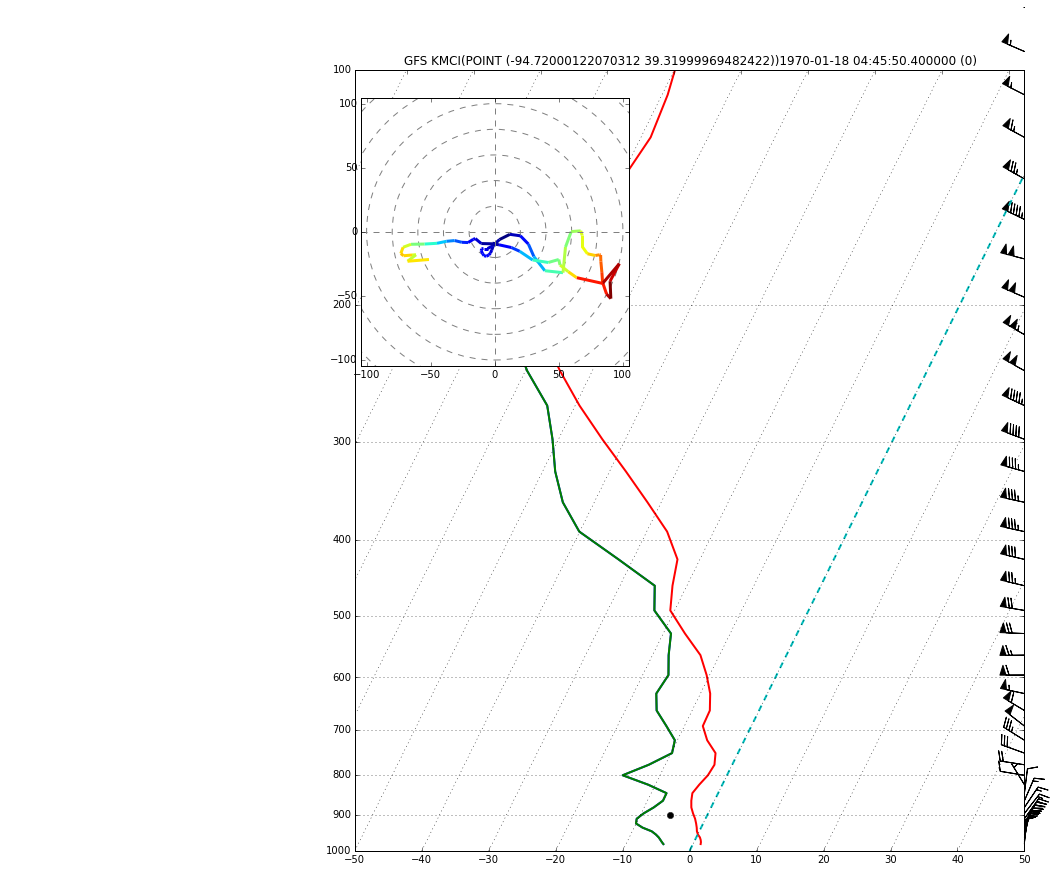

In [41]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 14)

# Create a skewT plot
skew = SkewT()

# Plot the data
skew.plot(p, t, 'r', linewidth=2)
skew.plot(p, td, 'b', linewidth=2)
skew.plot(p, td2, 'y')
skew.plot(p, dwpc, 'g', linewidth=2)

skew.plot_barbs(p, u, v)
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-40, 60)

plt.title(sounding_title)

# Calculate LCL height and plot as black dot
l = lcl(p[0], t[0], td[0])
lcl_temp = dry_lapse(concatenate((p[0], l)), t[0])[-1].to('degC')
skew.plot(l, lcl_temp, 'ko', markerfacecolor='black')


# An example of a slanted line at constant T -- in this case the 0 isotherm
l = skew.ax.axvline(0, color='c', linestyle='--', linewidth=2)

# Draw hodograph
ax_hod = inset_axes(skew.ax, '40%', '40%', loc=2)
h = Hodograph(ax_hod, component_range=get_wind_speed(u, v).max())
h.add_grid(increment=20)
h.plot_colormapped(u, v, spd)

# Show the plot
plt.show()